In [1]:
from scipy.io import wavfile  #提供wav檔的處理
import matplotlib.pyplot as plt  #提供類似matlab的繪圖API
import numpy as np  #提供數學計算函式庫

In [2]:
rate,data = wavfile.read("./sample_speech_signal.wav") #讀取.wav檔。返回一個tuple，分別為採樣率和數據的numpy數組
print("rate : " + str(rate) + " Hz")
print(str(len(data))+" datas")

rate : 44100 Hz
140288 datas


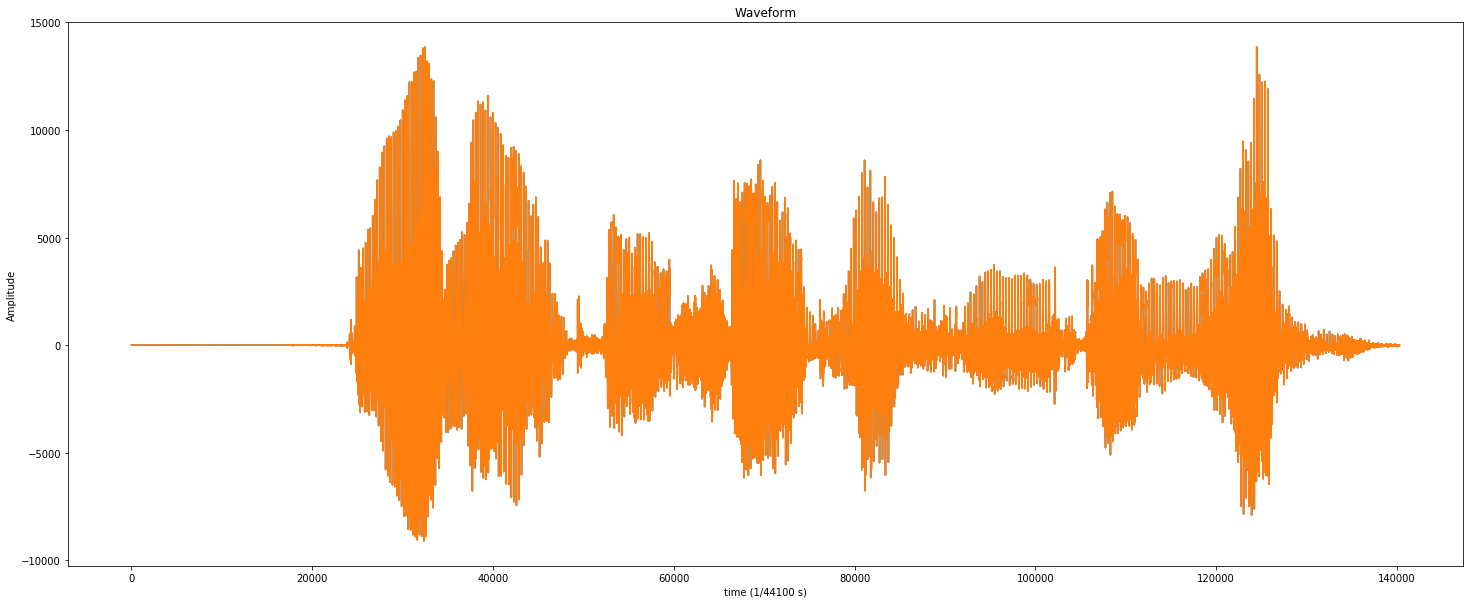

In [3]:
#(1) Waveform
plt.figure(figsize = [25,10])
plt.plot(data)
plt.title('Waveform')
plt.xlabel('time (1/44100 s)')
plt.ylabel('Amplitude')
plt.show()

length of data3 : 140238


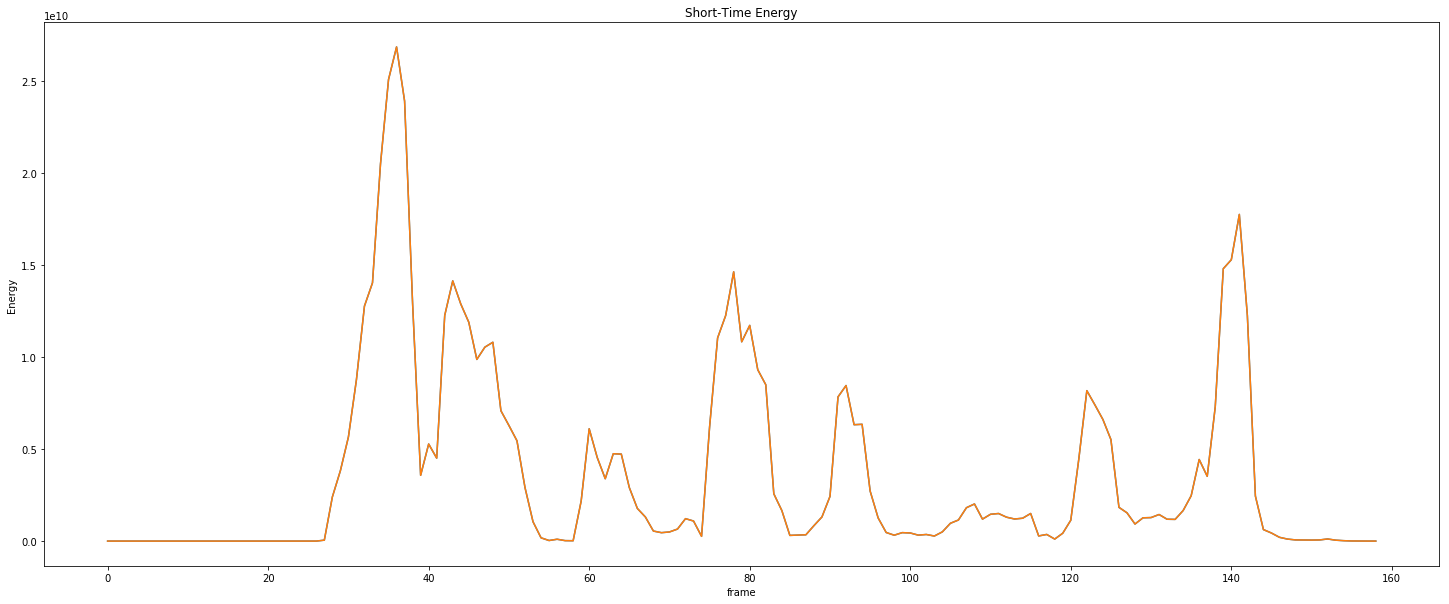

In [4]:
#(2) Energy contour 
#let frame size = 20ms, and 1 frame has 20ms*44100Hz = 882 datas, so there are (140288//882) = 159 frames.
#刪掉多餘的datas, (140288-140288%882) = 140238, 140288%882 =50.
data3 = data[:-50]
print("length of data3 :",len(data3))

Energy = []
for i in range(159):
    begin = i*882
    end = (i+1)*882
    w = np.zeros(data3.shape)
    w[begin:end] = 1  # Rectangular window  # w[begin] = (1,1) ... w[end] = (1,1)
    E = sum((data3*w)**2)
    Energy.append(E)

plt.figure(figsize=[25,10])
plt.plot(Energy)
plt.title('Short-Time Energy')
plt.xlabel('frame')
plt.ylabel('Energy')
plt.show()

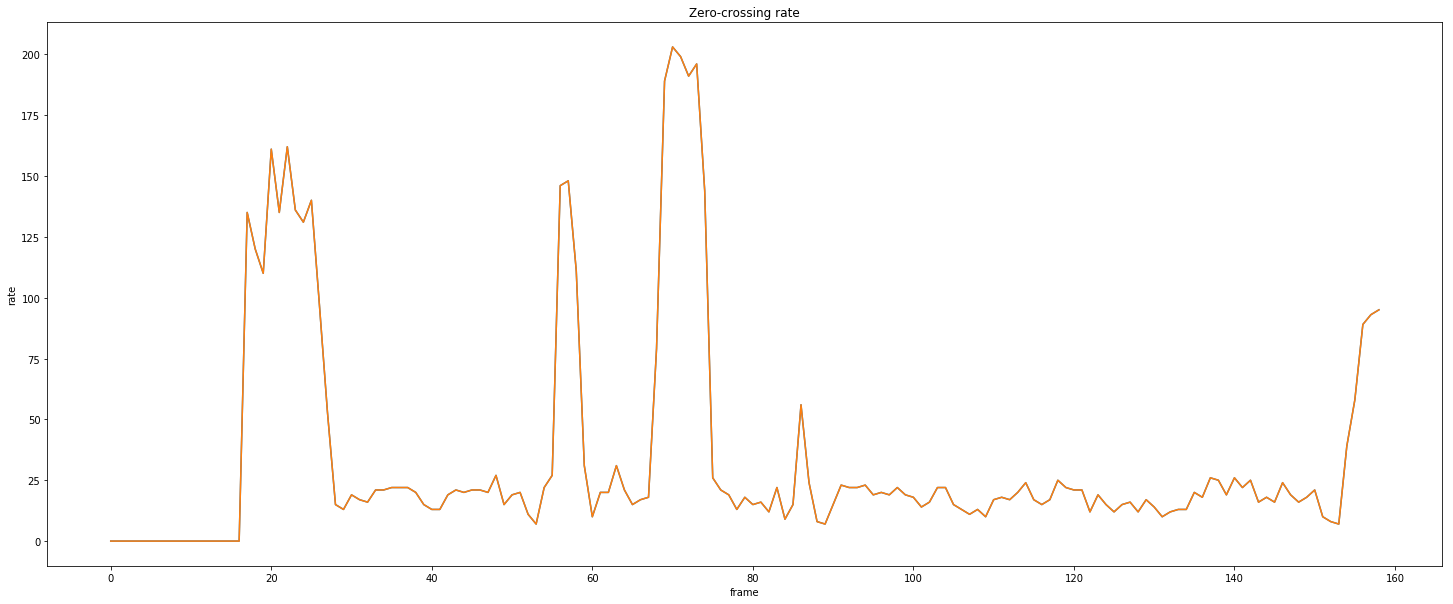

In [5]:
#(3) Zero-crossing rate contour
data5 = np.zeros(data3.shape)
data6 = np.zeros(data3.shape)

for i in range(len(data3)): #sgn[x(m)]
    if data3[i][0] >= 0:
        data5[i] = 1
    else:
        data5[i] = -1

data6[0] = 1
for i in range(len(data3)-1): #sgn[x(m-1)]
    if data3[i][0] >= 0:
        data6[i+1] = 1
    else:
        data6[i+1] = -1

Zero_crossing = []
for i in range(159):
    begin = i*882
    end = (i+1)*882
    w = np.zeros(data3.shape)
    w[begin:end] = 1/2
    ZCR = sum(abs(data5-data6)*w)
    Zero_crossing.append(ZCR)

plt.figure(figsize=[25,10])
plt.plot(Zero_crossing)
plt.title('Zero-crossing rate')
plt.xlabel('frame')
plt.ylabel('rate')
plt.show()
#Zero-crossing rate of unvoiced sounds and environmental noise are usually larger than voiced sounds.

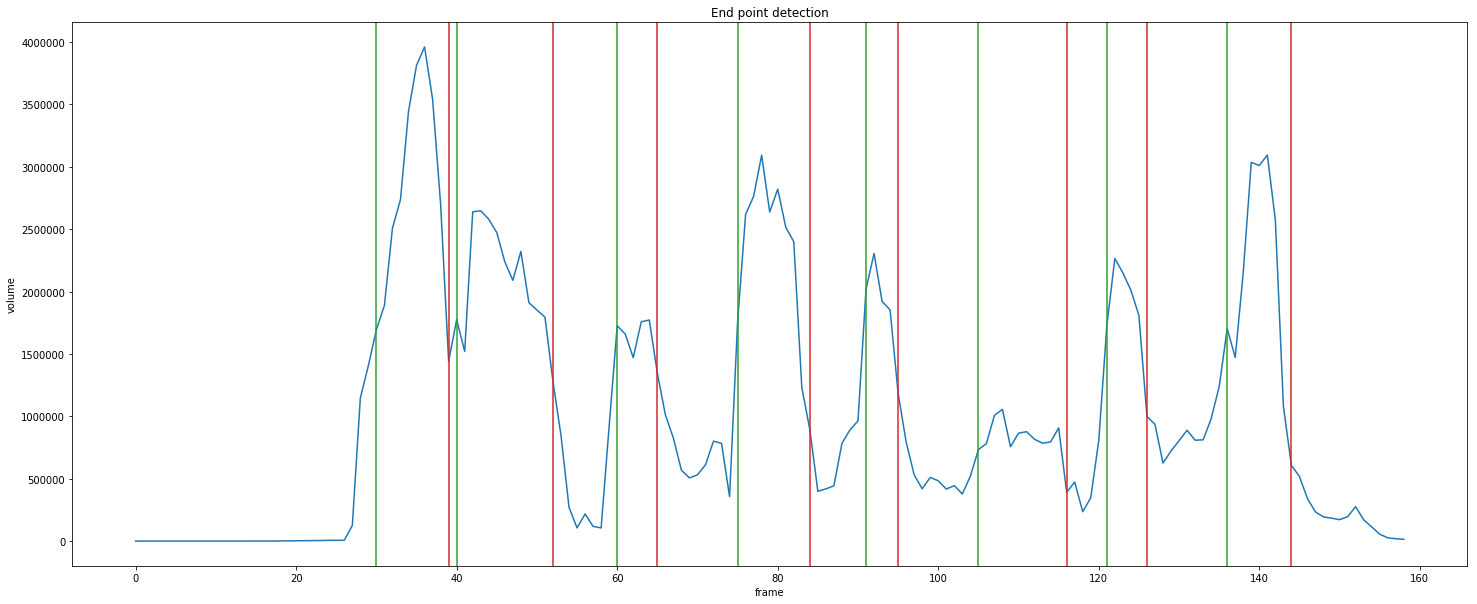

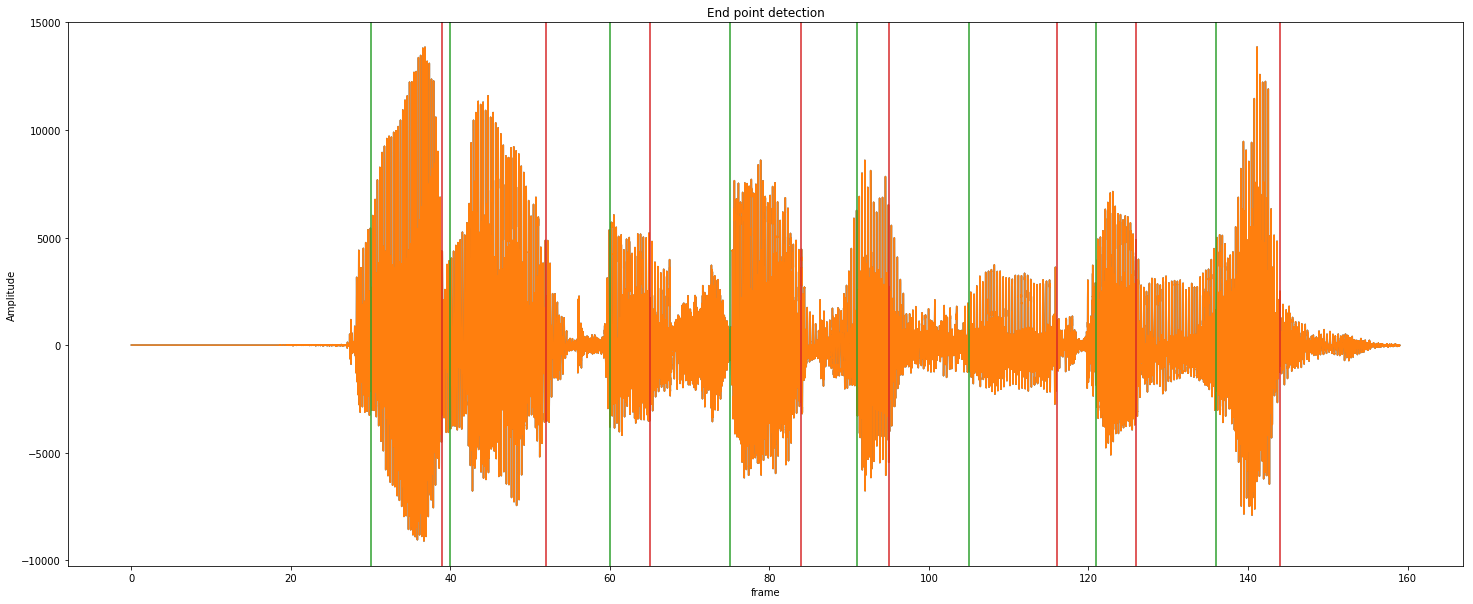

In [6]:
#(4) End point detection
sound_volume = []
Avg = []
Std = []

for i in range(159):
    begin = i*882
    end = (i+1)*882
    result = data3[begin:end] - np.median(data3[begin:end]) #apply median subtraction for zero justification
    sound_volume.append(sum(abs(result))[0]) #method of "abs sum"
    
for i in range(0,159,20):
    if i >= 140:
        Avg.append(sum(sound_volume[i:])/len(sound_volume[i:]))
        Std.append(np.std(sound_volume[i:]))
    else:
        Avg.append(sum(sound_volume[i:i+20])/len(sound_volume[i:i+20]))
        Std.append(np.std(sound_volume[i:i+20]))

start_point = []
end_point = []
Start = False

for i in range(len(sound_volume)):
    if sound_volume[i] > Avg[i//20] + 0.05*Std[i//20] and Start == False and sound_volume[i] > 300000:
        Start = True
        start_point.append(i)

    if sound_volume[i] < Avg[i//20] - 0.05*Std[i//20] and Start == True and sound_volume[i] > 300000:
        Start = False
        end_point.append(i)


plt.figure(figsize=[25,10])
plt.plot(sound_volume)
plt.title('End point detection')
plt.xlabel('frame')
plt.ylabel('volume')
for i in range(len(start_point)):
    plt.axvline(start_point[i],color='#2ca02c') #green
for i in range(len(end_point)):
    plt.axvline(end_point[i],color='#d62728') #red
plt.show()

#------------------------------------------------------
plt.figure(figsize=[25,10])
t = np.linspace(0,159,140238)
plt.plot(t, data3)
plt.title('End point detection')
plt.xlabel('frame')
plt.ylabel('Amplitude')
for i in range(len(start_point)):
    plt.axvline(start_point[i],color='#2ca02c') #green
for i in range(len(end_point)):
    plt.axvline(end_point[i],color='#d62728') #red
plt.show()

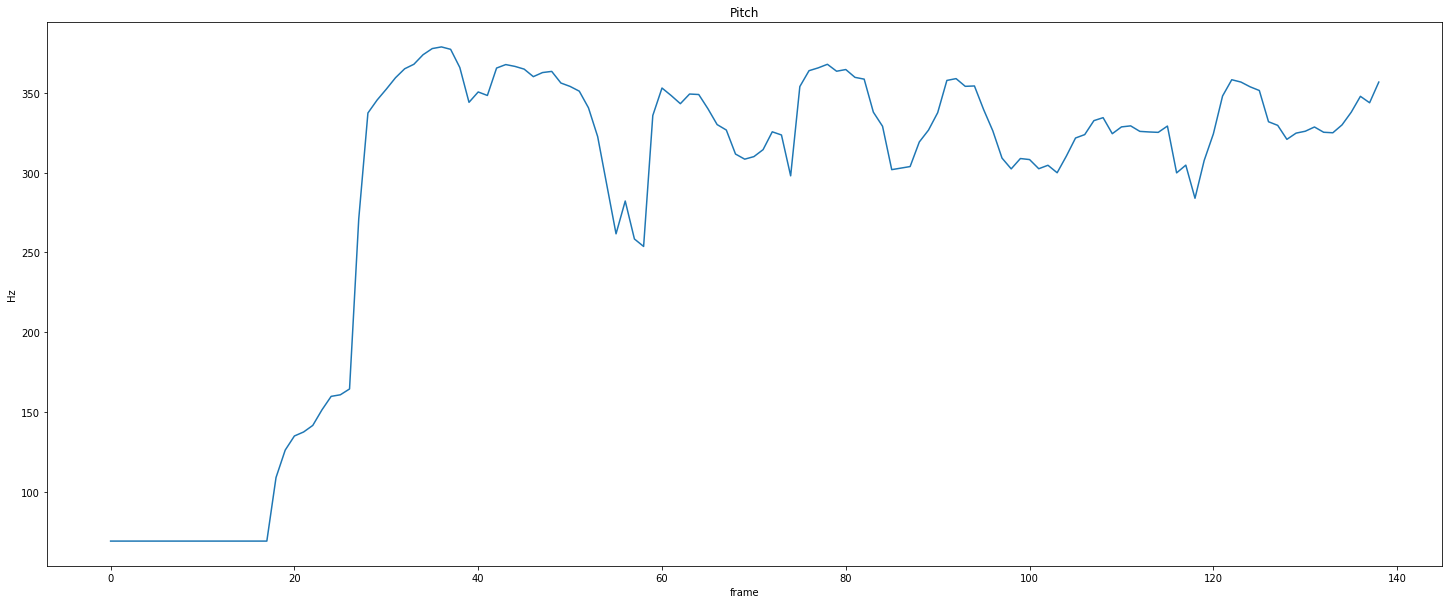

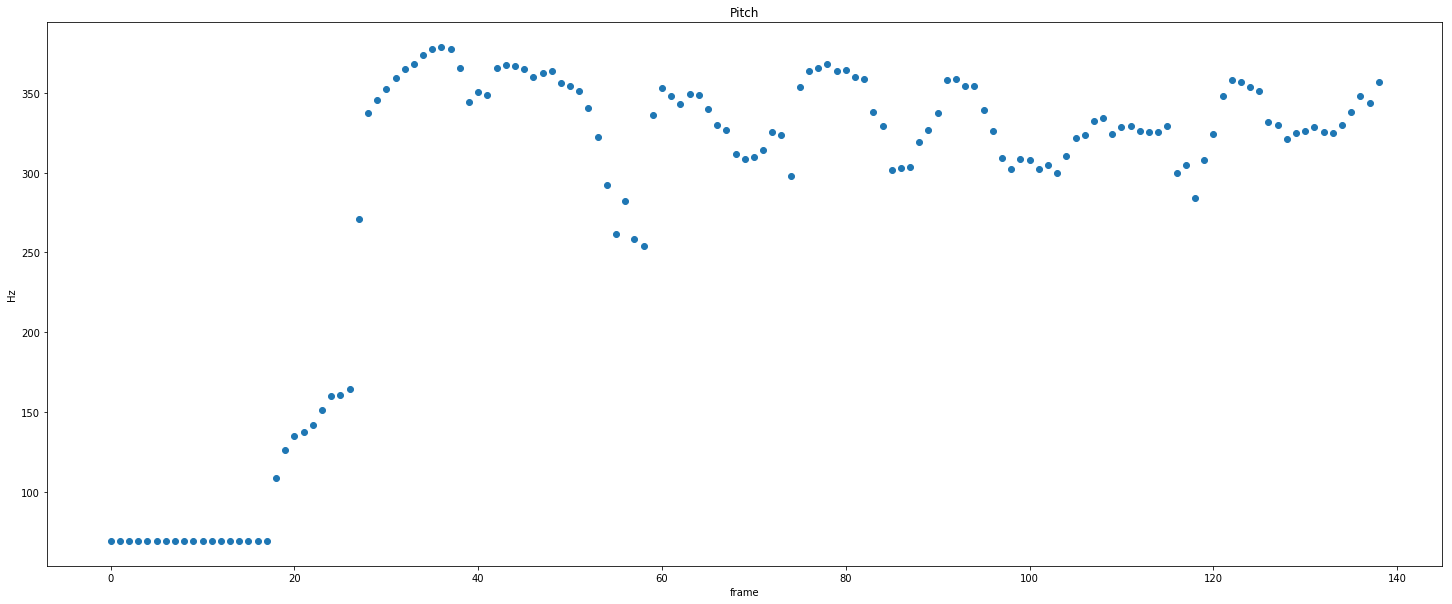

In [7]:
#(5) Pitch contour
# The frame size for pitch should cover at least two fundamental periods
# fundamental period = 44100 Hz / 100 Hz = 441 datas, frame size for pitch = 882 datas
# auto-correlation function (ACF) 

voice_pitch = []
k = 20  # k is the pitch period and varies from 20 to 400

for i in range(159-k): # 159
    begin = i*882
    end = (i+1)*882
    data9_1 = data3[begin:end]
    data9_2 = data3[begin+k:end+k]
    x1 = np.zeros(data3.shape)
    x1[begin:end] = data9_1
    x2 = np.zeros(data3.shape)
    x2[begin+k:end+k] = data9_2
    w1 = np.zeros(data3.shape)
    w1[begin:end] = 1
    w2 = np.zeros(data3.shape)
    w2[begin+k:end+k] = 1
    autocorrelation = sum(x1*w1*x2*w2) # sum[x(m)*w1(n-m)*x(m+k)*w2(n-m-k)]
    #數學上，音高和基本頻率的關係：p = 69 + 12*log2(f/440) 
    if autocorrelation[0] == 0:
        p = 69
    else:
        p = 69 + 12*np.log2(autocorrelation[0]//440)
    voice_pitch.append(p)


plt.figure(figsize=[25,10])
plt.plot(voice_pitch)
plt.title('Pitch')
plt.xlabel('frame')
plt.ylabel('Hz')
plt.show()

plt.figure(figsize=[25,10])
xx = np.arange(0,len(voice_pitch))
plt.scatter(xx,voice_pitch)
plt.title('Pitch')
plt.xlabel('frame')
plt.ylabel('Hz')
plt.show()

#男生的音高範圍約在頻率 62 ~ 523 Hz。

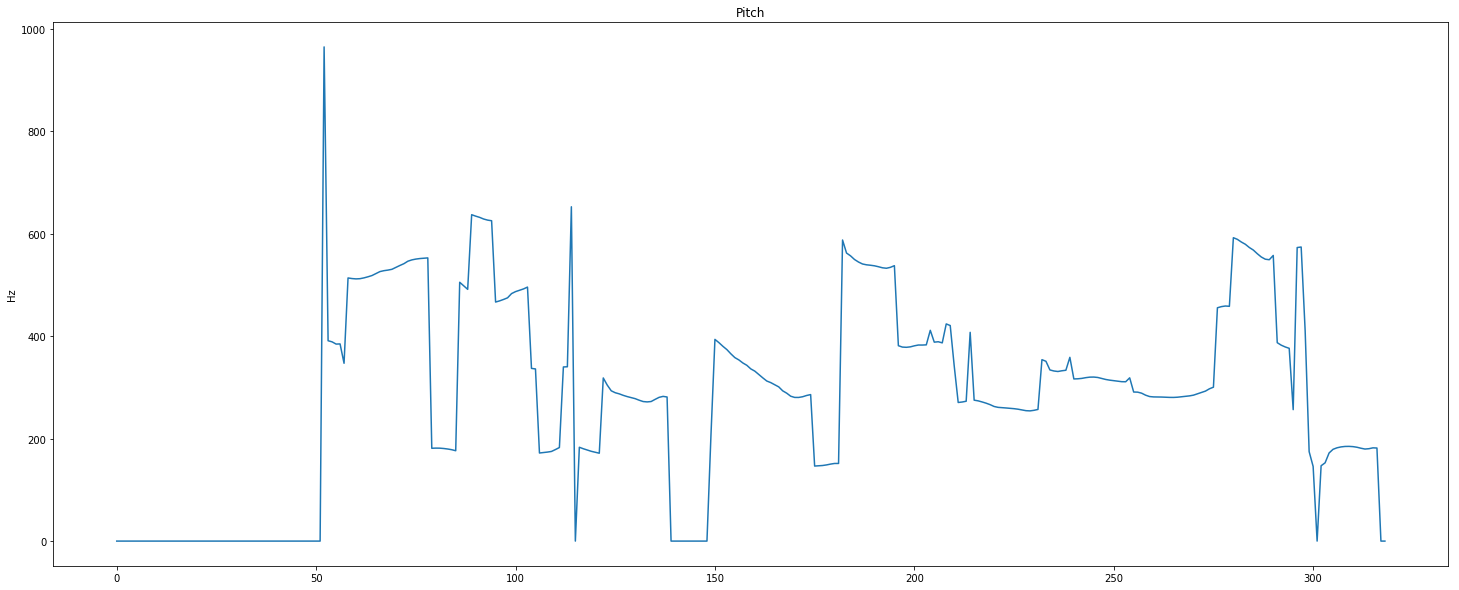

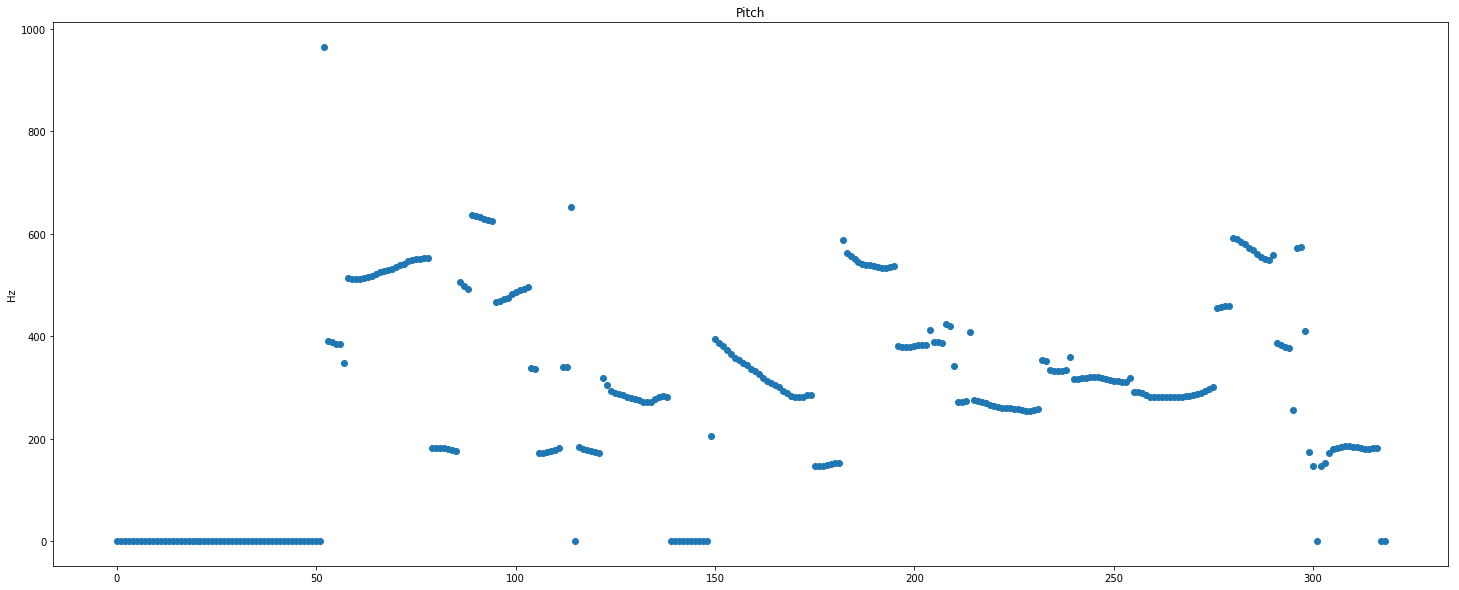

In [8]:
import librosa
wave,fs = librosa.load('sample_speech_signal.wav')
#print(fs) # 22050
#print(len(wave)) # 70144
pitches,magnitudes = librosa.core.piptrack(wave,fs,hop_length=int(10 * fs /1000),threshold=0.75)
#print(len(pitches)) # 1025

max_pitch = []
for i in range(pitches.shape[1]):
    max_ = np.max(pitches[:,i])
    if max_>1000 :
        max_ = 0 # 如果超過合理的音高範圍，就認定沒有音高存在
    max_pitch.append(max_)


#print(len(max_pitch)) #319

plt.figure(figsize=[25,10])
plt.plot(max_pitch)
plt.title('Pitch')
plt.ylabel('Hz')
plt.show()

plt.figure(figsize=[25,10])
xx = np.arange(0,len(max_pitch))
plt.scatter(xx,max_pitch)
plt.title('Pitch')
plt.ylabel('Hz')
plt.show()

#男生的音高範圍約在頻率 62 ~ 523 Hz。

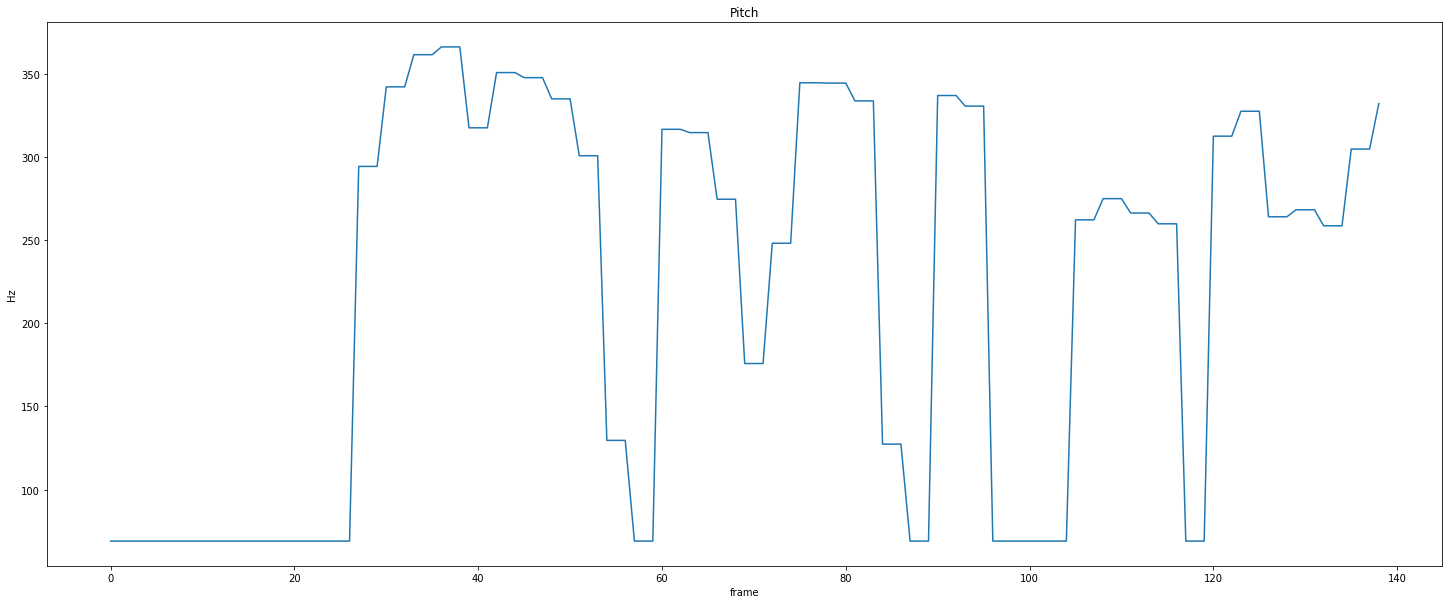

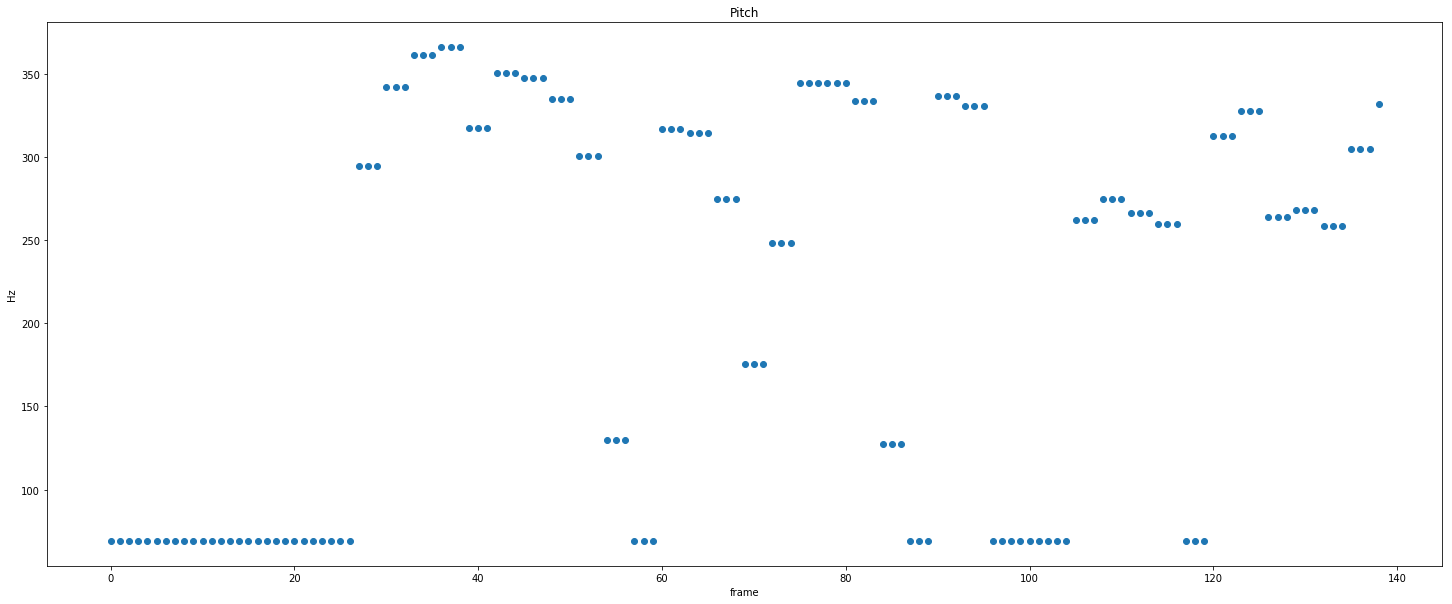

In [9]:
#(5) Pitch contour
# The frame size for pitch should cover at least two fundamental periods
# fundamental period = 44100 Hz / 100 Hz = 441 datas, frame size for pitch = 882 datas
# auto-correlation function (ACF) 

# Center Clipping
data7 = []
CL = 2000
for i in range(len(data3)):
    if data3[i][0] > CL:
        data7.append(data3[i][0] - CL)
    elif data3[i][0] < (-CL):
        data7.append(data3[i][0] + CL)
    else:
        data7.append(0)


voice_pitch = []
k = 20  # k is the pitch period and varies from 20 to 400

for i in range(159-k): # 159
    begin = i*882
    end = (i+1)*882
    data9_1 = data7[begin:end]
    data9_2 = data7[begin+k:end+k]
    x1 = np.zeros(len(data7))
    x1[begin:end] = data9_1
    x2 = np.zeros(len(data7))
    x2[begin+k:end+k] = data9_2
    w1 = np.zeros(len(data7))
    w1[begin:end] = 1
    w2 = np.zeros(len(data7))
    w2[begin+k:end+k] = 1
    autocorrelation = sum(x1*w1*x2*w2) # sum[x(m)*w1(n-m)*x(m+k)*w2(n-m-k)]
    #數學上，音高和基本頻率的關係：p = 69 + 12*log2(f/440) 
    if autocorrelation == 0:
        p = 69
    else:
        p = 69 + 12*np.log2(autocorrelation//440)
    voice_pitch.append(p)


# Median Smoothing
for i in range(0,len(voice_pitch)-len(voice_pitch)%3,3):
    median_pitch = np.median(voice_pitch[i:i+3])
    for j in range(3):
        voice_pitch[i+j] = median_pitch


plt.figure(figsize=[25,10])
plt.plot(voice_pitch)
plt.title('Pitch')
plt.xlabel('frame')
plt.ylabel('Hz')
plt.show()

plt.figure(figsize=[25,10])
xx = np.arange(0,len(voice_pitch)) # 159-k
plt.scatter(xx,voice_pitch)
plt.title('Pitch')
plt.xlabel('frame')
plt.ylabel('Hz')
plt.show()

#男生的音高範圍約在頻率 62 ~ 523 Hz。